In [ ]:
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=59923edc349071884e4164820b902fca07d432446647e9d496f454854a62dab1
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
import os 
import sys
import json  
import time
from   datetime                import date
  
import pandas                  as pd
import numpy                   as np 
import matplotlib.pyplot       as plt  
import seaborn                 as sn
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow              as tf
from   tensorflow              import keras
from   tensorflow.keras        import layers, Input, backend
from   tensorflow.keras.layers import Dense, Activation, ZeroPadding2D, BatchNormalization, Conv2D, Permute
from   tensorflow.keras.layers import Lambda, Bidirectional, LSTM, GRU, Dot, Softmax
from   tensorflow.keras.models import Model

from   scipy.io                import wavfile
from   python_speech_features  import mfcc, logfbank
import wave 

import itertools
import cProfile
from IPython.display            import Audio

# Colab and Drive Libraries
from   google.colab            import drive

## Mounting Google's Drive (only for data purposes)

In [ ]:
drive.mount('/content/drive') # to attempt to forcibly remount -> force_remount=True

# paths
FRA_PATH, FEDE_PATH = "/content/drive/MyDrive/University/HDA/HDA_Project/project", "/content/drive/MyDrive"

# Setting the working directory 
# os.chdir(FRA_PATH)
os.chdir(FEDE_PATH)

Mounted at /content/drive


## Utils

In [ ]:
sys.path.append('./src/features')
sys.path.append('./src/data')
sys.path.append('./src/models')

In [ ]:
import constants as cs
import feature_utils  as fs
import data_utils     as ds
import training_utils as ts

## Graphic Settings

In [ ]:
ds.set_dark_theme() if input("Are you in dark mode? y/n:   ").lower() == "y" else print("Hurts your eyes")

Are you in dark mode? y/n:   y


## Filepaths

In [ ]:
#  Path of .npy files
BINARIES_PATH = "data/binaries/"

## Loading Binaries

In [ ]:
X_train = np.load(BINARIES_PATH + "X_train.npy")
X_valid = np.load(BINARIES_PATH + "X_valid.npy")
X_test = np.load(BINARIES_PATH + "X_test.npy")

y_train = np.load(BINARIES_PATH + "y_train.npy")
y_valid = np.load(BINARIES_PATH + "y_valid.npy")
y_test = np.load(BINARIES_PATH + "y_test.npy")

### Extracting first 13 dimensions from them

In [ ]:
X_train_envelope, X_valid_envelope, X_test_envelope = ds.envelope_coefficients(X_train), ds.envelope_coefficients(X_valid), ds.envelope_coefficients(X_test)

In [ ]:
# checking dimensions
print("X_train: ", X_train_envelope.shape,  "\ny_train: ", y_train.shape, "\nX_valid: ", X_valid_envelope.shape, "\ny_valid: ", y_valid.shape, "\nX_test: ", X_test_envelope.shape,  "\ny_test: ",  y_test.shape)

X_train:  (30769, 13, 99) 
y_train:  (30769,) 
X_valid:  (3703, 13, 99) 
y_valid:  (3703,) 
X_test:  (4074, 13, 99) 
y_test:  (4074,)


In [ ]:
X_train_envelope, y_train = ts.reshape(X_train_envelope, y_train)
X_valid_envelope, y_valid = ts.reshape(X_valid_envelope, y_valid)
X_test_envelope, y_test = ts.reshape(X_test_envelope, y_test)

In [ ]:
# checking dimensions
print("X_train: ", X_train_envelope.shape,  "\ny_train: ", y_train.shape, "\nX_valid: ", X_valid_envelope.shape, "\ny_valid: ", y_valid.shape, "\nX_test: ", X_test_envelope.shape,  "\ny_test: ",  y_test.shape)

X_train:  (30769, 13, 99, 1) 
y_train:  (30769, 1) 
X_valid:  (3703, 13, 99, 1) 
y_valid:  (3703, 1) 
X_test:  (4074, 13, 99, 1) 
y_test:  (4074, 1)


# Recurrent Neural Network Architecture with  Attention Mechanism

The main sequence on which we will base the training of the neural networks is: 

1. Build the model
2. Train the model
3. Evaluate the model 
4. Plot performance of the model
5. Predictions and confusion matrix of the model
6. Visualize attention plots
7. Save the model

In [ ]:
# Hyperparameters 
EPOCHS = 100
BATCH_SIZE = 32
PATIENCE = 10

# Parameters
INPUT_SHAPE = np.shape(X_train_envelope[-1,:,:,:])
NUM_CATEGORIES = cs.num_categories_reduced
LABELS_10_CLASSES = cs.labels_10_classes

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### 1. Build the model

In [ ]:
# Create network
model_name = 'att_lstm_model_reduced'
model = ts.att_rnn_architecture(name = model_name, input_shape = INPUT_SHAPE, num_classes = NUM_CATEGORIES)

Model: "att_lstm_model_reduced"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 13, 99, 1)]  0           []                               
                                                                                                  
 permute (Permute)              (None, 99, 13, 1)    0           ['input[0][0]']                  
                                                                                                  
 batch_norm0 (BatchNormalizatio  (None, 99, 13, 1)   4           ['permute[0][0]']                
 n)                                                                                               
                                                                                                  
 conv0 (Conv2D)                 (None, 99, 13, 10)   60          ['batch_norm

### 2. Train the model 

In [ ]:
# train network
history = ts.rnn_training(model = model,
                model_name = model_name, 
                epochs = EPOCHS, 
                batch_size = BATCH_SIZE, 
                patience = PATIENCE, 
                X_train = X_train_envelope, 
                y_train = y_train, 
                X_validation = X_valid_envelope, 
                y_validation = y_valid)

Epoch 1/100
962/962 [==============================] - 48s 30ms/step - loss: 0.6092 - sparse_categorical_accuracy: 0.7956 - val_loss: 0.3070 - val_sparse_categorical_accuracy: 0.8936 - lr: 0.0010
Epoch 2/100
962/962 [==============================] - 23s 24ms/step - loss: 0.2633 - sparse_categorical_accuracy: 0.9133 - val_loss: 0.2185 - val_sparse_categorical_accuracy: 0.9257 - lr: 0.0010
Epoch 3/100
962/962 [==============================] - 21s 21ms/step - loss: 0.1809 - sparse_categorical_accuracy: 0.9381 - val_loss: 0.2190 - val_sparse_categorical_accuracy: 0.9276 - lr: 0.0010
Epoch 4/100
962/962 [==============================] - 20s 21ms/step - loss: 0.1422 - sparse_categorical_accuracy: 0.9529 - val_loss: 0.2264 - val_sparse_categorical_accuracy: 0.9230 - lr: 0.0010
Epoch 5/100
962/962 [==============================] - 21s 22ms/step - loss: 0.1181 - sparse_categorical_accuracy: 0.9604 - val_loss: 0.2014 - val_sparse_categorical_accuracy: 0.9322 - lr: 0.0010
Epoch 6/100
962/962 

### 3. Evaluate the model 

In [ ]:
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test_envelope, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))  

128/128 [==============================] - 1s 10ms/step - loss: 0.2061 - sparse_categorical_accuracy: 0.9548

Test loss: 0.20613518357276917, test accuracy: 95.48355340957642


### 4. Plot performance of the model

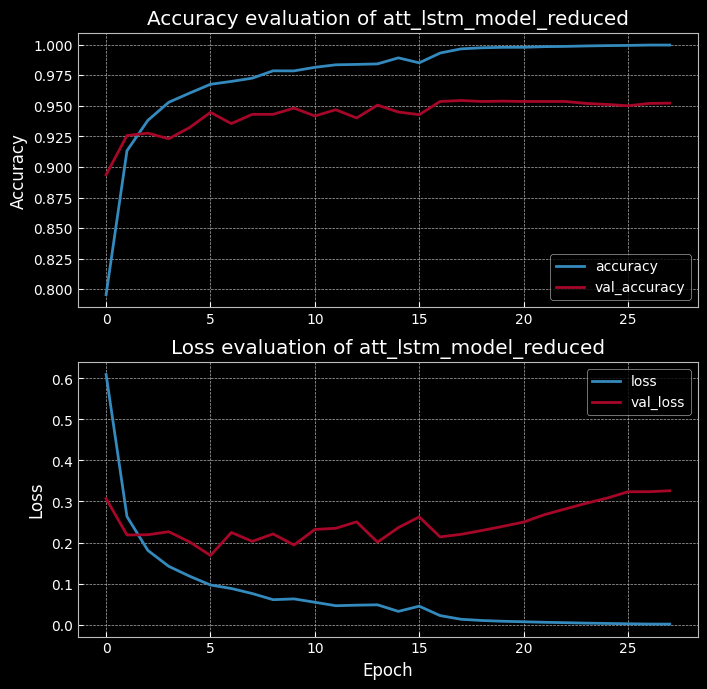

In [ ]:
# plot the performances
ts.plot_history(history, model_name, filename='accuracy_loss_{}.png'.format(model_name))

### 5. Predictions and confusion matrix of the model

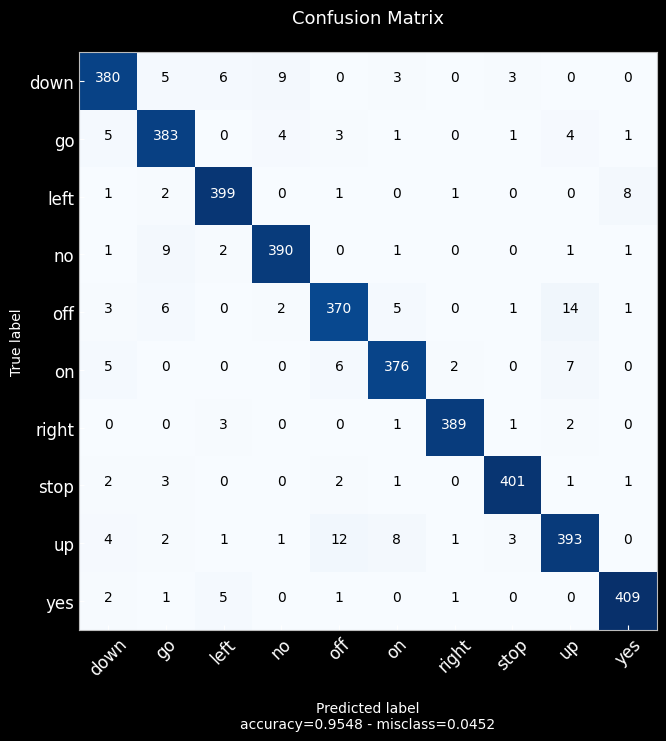

In [ ]:
y_pred = model.predict(X_test_envelope, verbose=0)
matrix  = confusion_matrix(y_test, y_pred.argmax(axis=1))
ts.plot_confusion_matrix(matrix, LABELS_10_CLASSES)

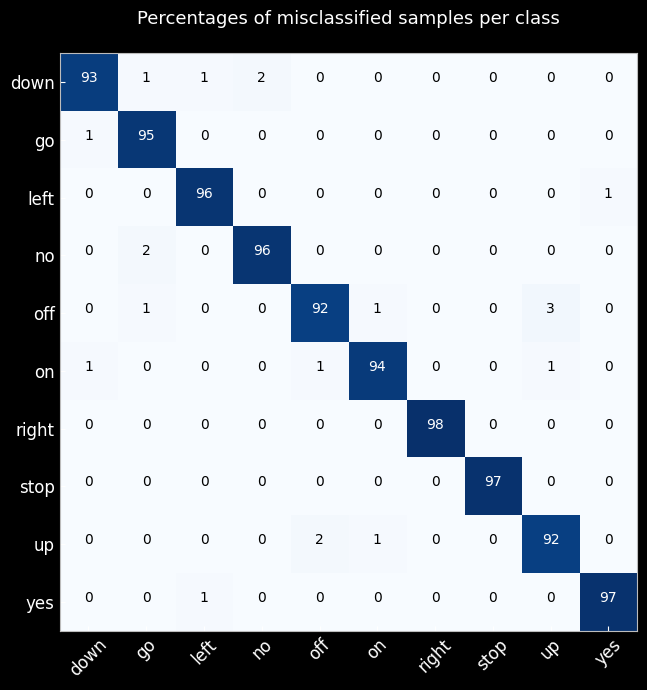

In [ ]:
percentages_misclassified_samples = np.ones_like(matrix)
sums = np.sum(matrix, axis = 1)

for i in range(matrix.shape[0]):
    percentages_misclassified_samples[i] = matrix[i] / sums[i] * 100

# percentages_misclassified_samples
ts.plot_confusion_matrix(percentages_misclassified_samples, LABELS_10_CLASSES, title = "Percentages of misclassified samples per class", display_metrics = False)

Prediction time

In [ ]:
ts.prediction_time(model, X_test_envelope)

Average prediction time (ms): 51.528750240773505


### 6. Visualize attention plots

In [ ]:
DATASET_PATH = "data/raw/dataset_v2_reduced/"

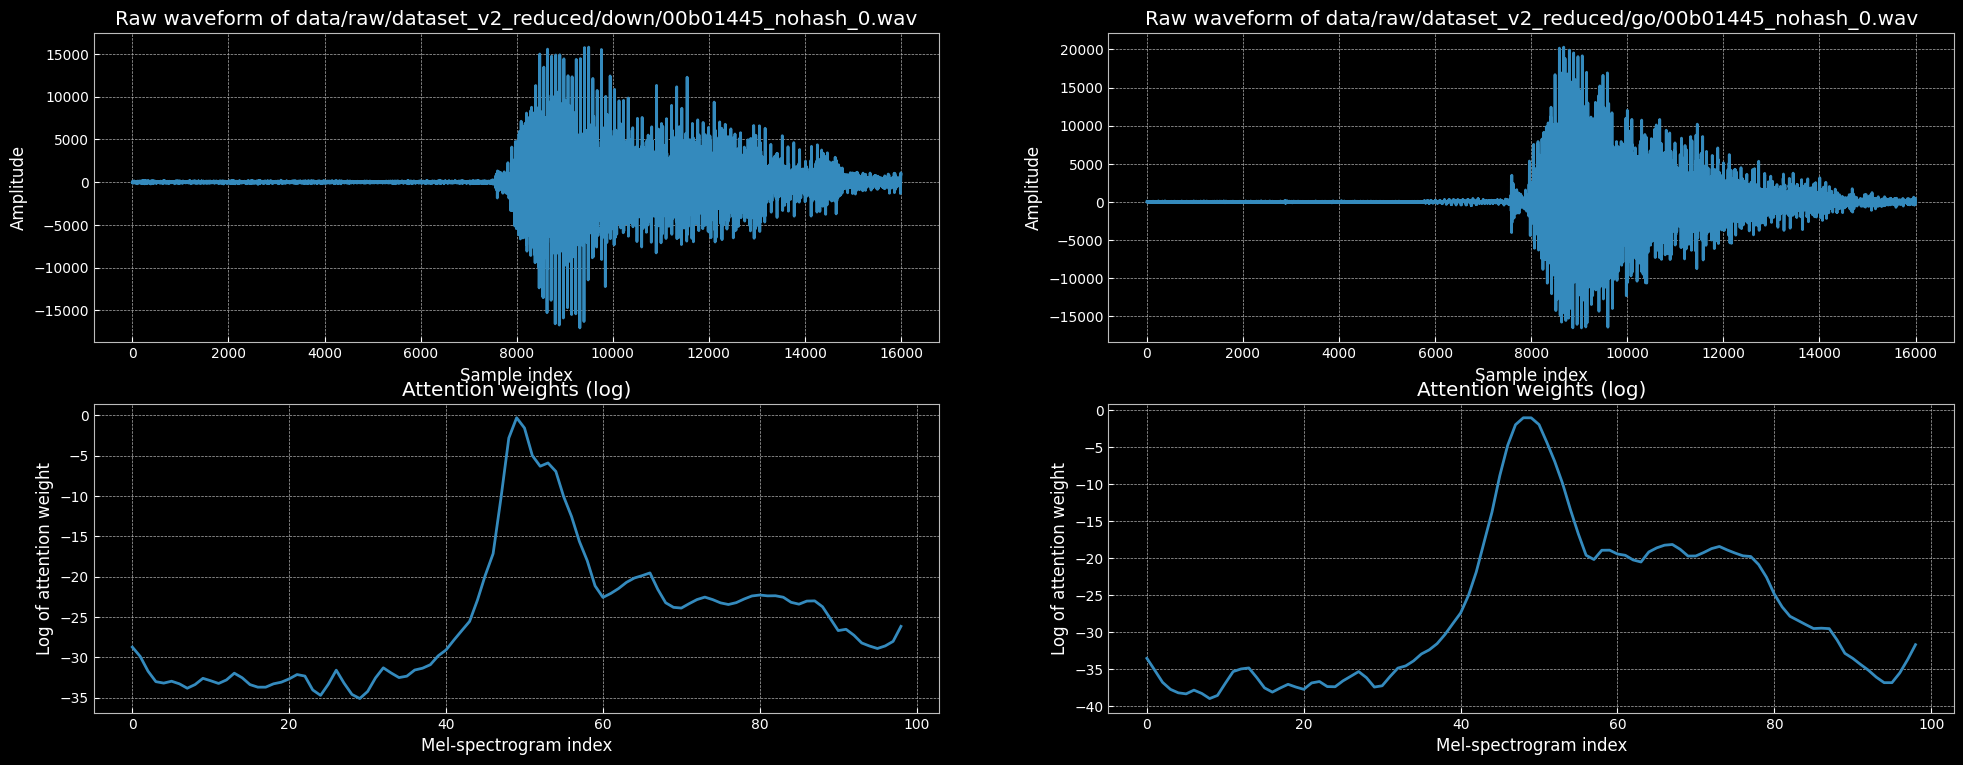

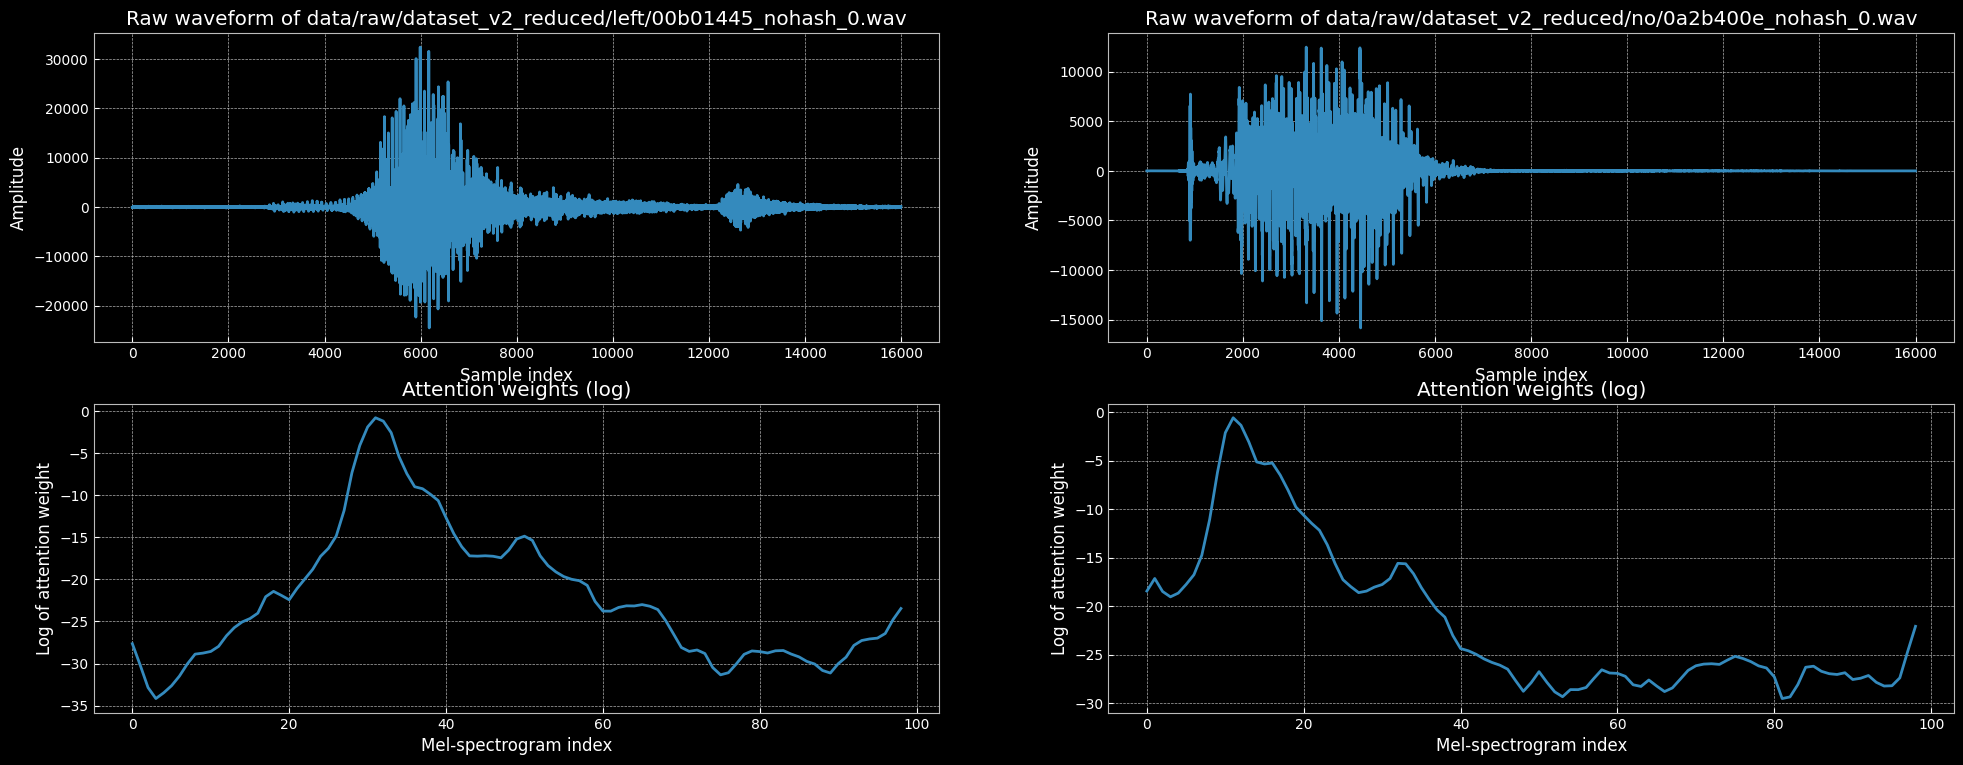

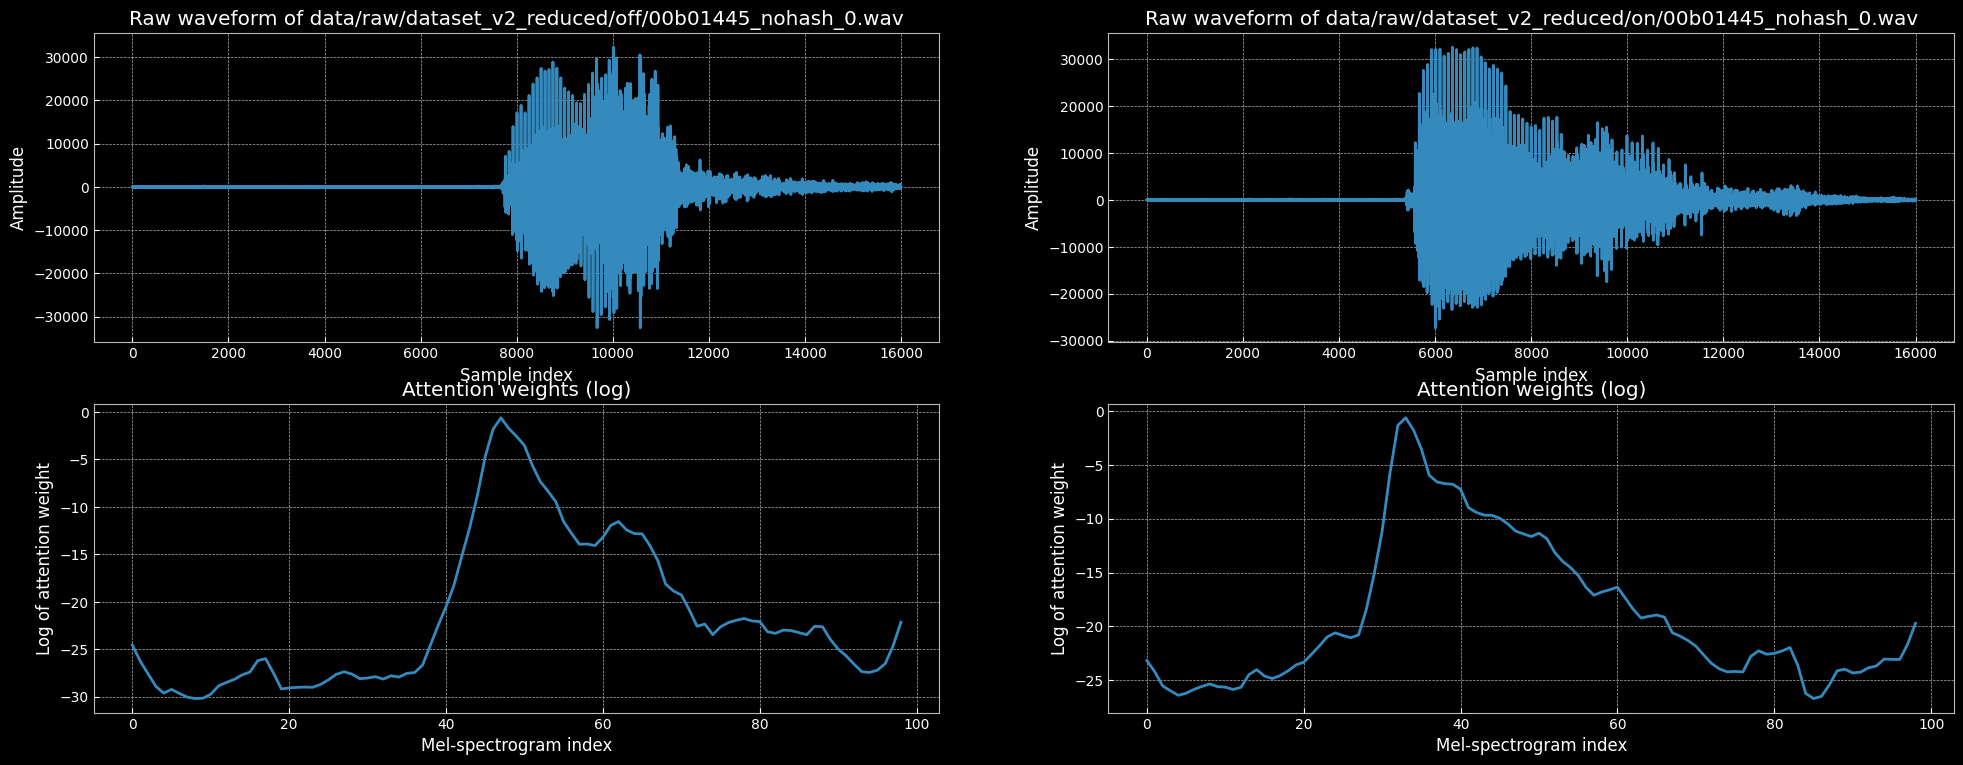

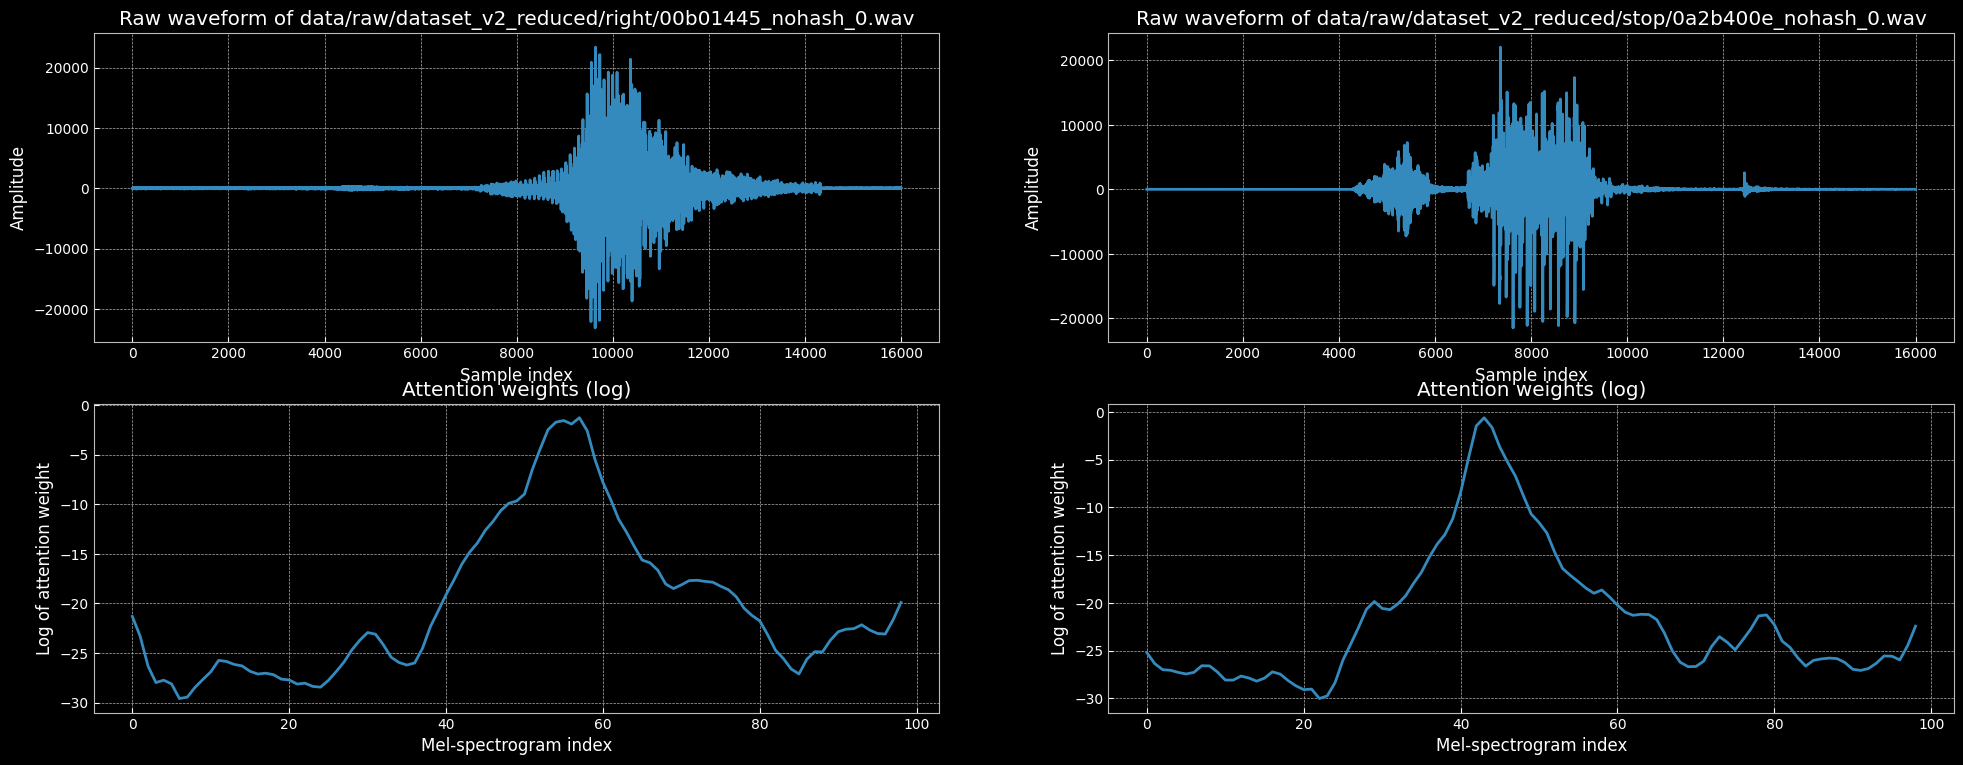

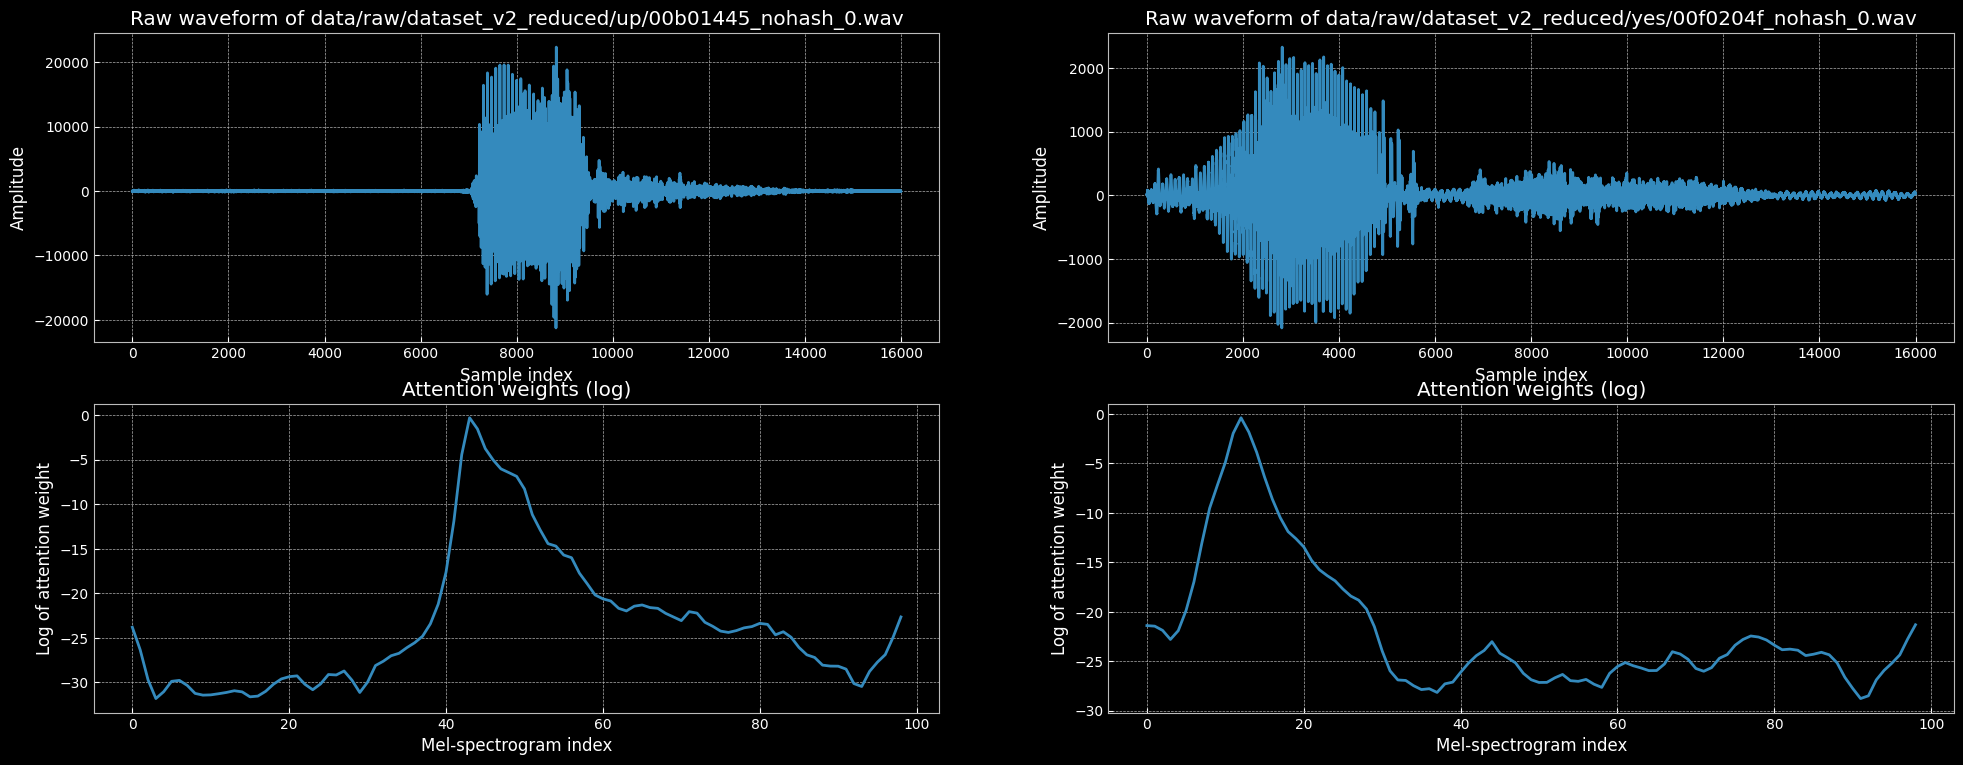

In [ ]:
 num_plots = NUM_CATEGORIES
 for i in np.arange(0, num_plots, 2, dtype=int):
   ds.plots_attention_dataset(DATASET_PATH, NUM_CATEGORIES, LABELS_10_CLASSES, model, i)

### 7. Save the model

In [ ]:
# save model
model.save('{}.h5'.format(model._name))